In [2]:
import os
import copy
import functools
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import lmfit
import corner

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [3]:
siv_path = "../data/20210303_stitched/"
prefix = "sweeper_fwd_avg_"
siv_files = []
for file in os.listdir(siv_path):
    if file.startswith(prefix) and file.endswith(".txt"):
        siv_files.append(file[len(prefix):])
        
print(siv_files)

['10_17_58.txt', '10_47_04.txt', '11_06_07.txt', '11_14_47.txt', '11_22_49.txt', '11_28_41.txt']


# Plot SiV Data

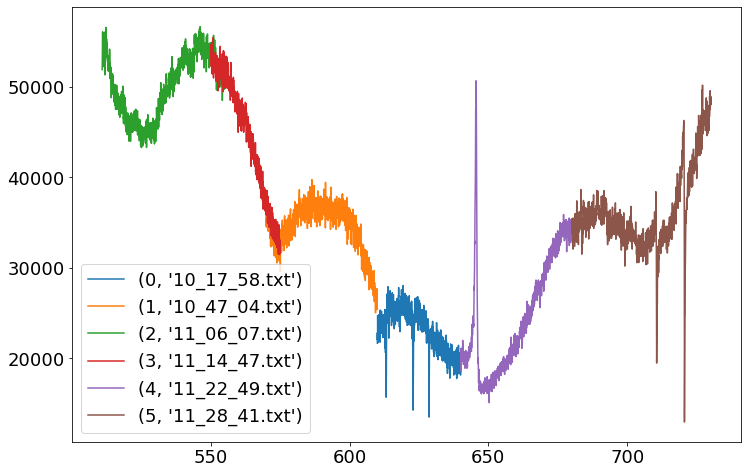

In [4]:
cavity_freqs = []
cavity_intensity = []

color = plt.cm.jet(np.linspace(0, 1, len(siv_files)))
plt.figure(figsize=[12, 8])

for i, file in enumerate(siv_files):
    freqs, intensity = np.loadtxt(siv_path + prefix + file)
    freqs = 1000 * (freqs - 406) # Re-center, convert to GHz
    plt.plot(freqs, intensity, label=(i, file))
    
    cavity_freqs.extend(freqs)
    cavity_intensity.extend(intensity)
plt.legend()

# Sort by frequency values
cavity_freqs, cavity_intensity = zip(*sorted(zip(cavity_freqs, cavity_intensity)))
cavity_freqs, cavity_intensity = np.array(cavity_freqs), np.array(cavity_intensity)

## Plot Filter ranges to remove SiV peaks

In [5]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(612, 615), (621.5, 624.5), (627.5, 629.5), (643, 647.5), (709, 712), (718.5, 722.5)]

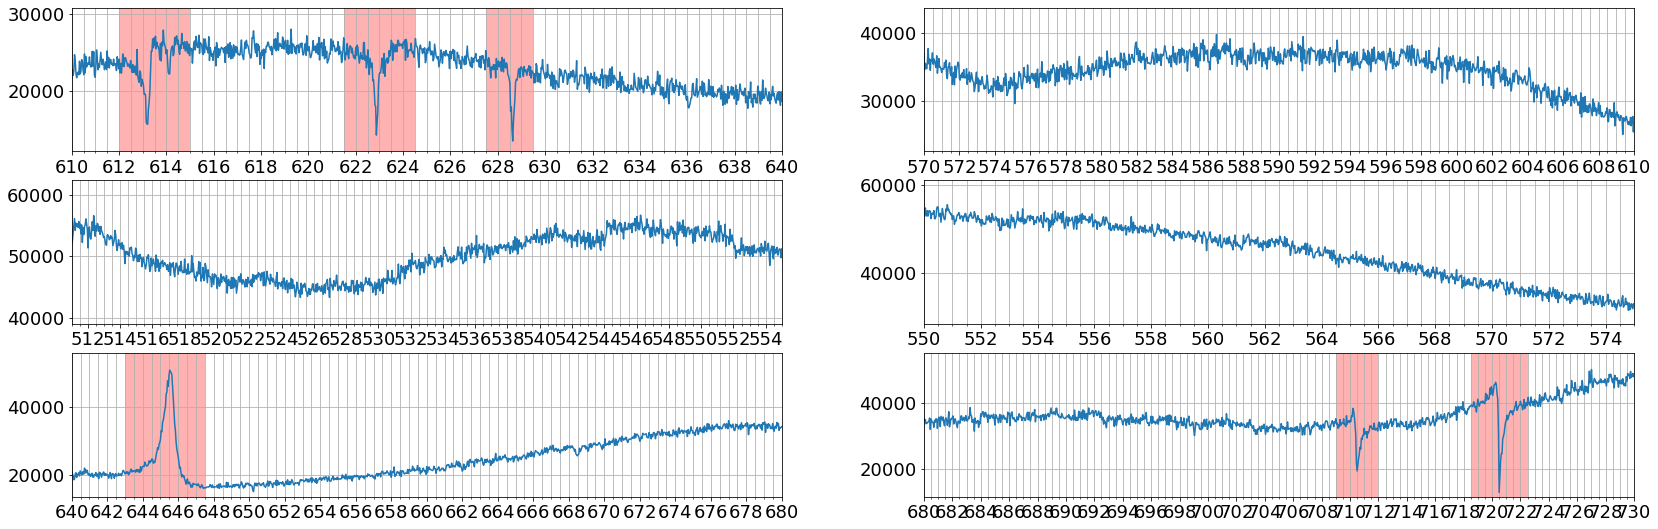

In [6]:
fig, ax = plt.subplots(figsize=[28, 9], nrows=3, ncols=2)
for i, file in enumerate(siv_files):
    axes = ax[i//2, i%2]    
    freqs, intensity = np.loadtxt(siv_path + prefix + file)
    freqs = 1000 * (freqs - 406) # Re-center, convert to GHz
    axes.plot(freqs, intensity)
    
    for start, end in filter_range:
        axes.add_patch(patches.Rectangle((start, 0), (end-start), 70000, facecolor='red', alpha=0.3))
        
    axes.set_xlim([min(freqs), max(freqs)])
    axes.set_ylim([0.9 * min(intensity), 1.1 * max(intensity)])
    
    axes.xaxis.set_major_locator(MultipleLocator(2))
    axes.xaxis.set_minor_locator(MultipleLocator(0.5))
    axes.grid(which='both')

## Filtering out SiV Peaks

In [7]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

def in_range(arr, ranges):
    """ Returns indices of `arr` that lie in any of the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # OR of (x >= start AND x <= end) leads to all x that are 
    # inside of any (start, end) range.
    for start, end in ranges:
        conditions.append((arr >= start) & (arr <= end)) 
    return np.where(functools.reduce(np.logical_or, conditions))

Text(0.5, 1.0, 'Filtered cavity spectrum')

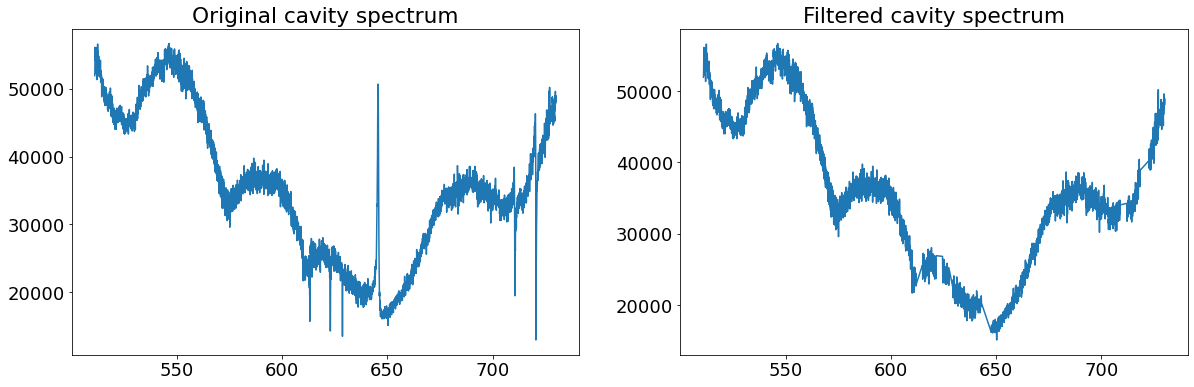

In [8]:
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

fig, ax = plt.subplots(figsize=[20, 6], ncols=2)
ax[0].plot(cavity_freqs, cavity_intensity)
ax[0].set_title("Original cavity spectrum")
ax[1].plot(cavity_freqs_filtered, cavity_intensity_filtered)
ax[1].set_title("Filtered cavity spectrum")

# ----------------------------------------------------------
# Fit Cavity Spectrum

## Fit cavity function to filtered cavity scan

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 5487
    # variables        = 4
    chi-square         = 9.3645e+10
    reduced chi-square = 17079133.3
    Akaike info crit   = 91381.0288
    Bayesian info crit = 91407.4693
[[Variables]]
    w_c:    642.845773 +/- 0.21788100 (0.03%) (init = 650)
    k_in:   53.4549408 +/- 0.73387416 (1.37%) (init = 100)
    k_tot:  67.5904494 +/- 0.94610249 (1.40%) (init = 100)
    A:      60381.5756 +/- 398.479500 (0.66%) (init = 40000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.996
    C(k_tot, A)    =  0.922
    C(k_in, A)     =  0.889
    C(w_c, A)      = -0.129


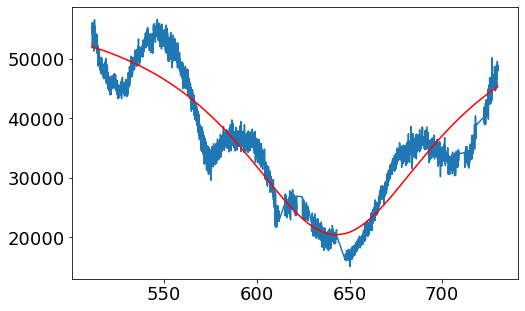

In [9]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=650, min=640, max=660),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0, vary=False),
)

results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered)
lmfit.report_fit(results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs_filtered, cavity_ref_model.eval(params=results.params, w=cavity_freqs_filtered), 'r')

fit_ratio = cavity_intensity_filtered / cavity_ref_model.eval(params=results.params, w=cavity_freqs_filtered)

### Fit sinusoidal to fitted cavity ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 5487
    # variables        = 4
    chi-square         = 40.3748404
    reduced chi-square = 0.00736364
    Akaike info crit   = -26943.7605
    Bayesian info crit = -26917.3200
[[Variables]]
    w:    0.14032064 +/- 3.0330e-04 (0.22%) (init = 0.125)
    phi:  6.27999999 +/- 0.01317989 (0.21%) (init = 2)
    A:    0.09373852 +/- 0.00160255 (1.71%) (init = 0.2)
    B:    1.00231573 +/- 0.00117310 (0.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) = -0.995
    C(phi, B) =  0.148
    C(w, B)   = -0.143


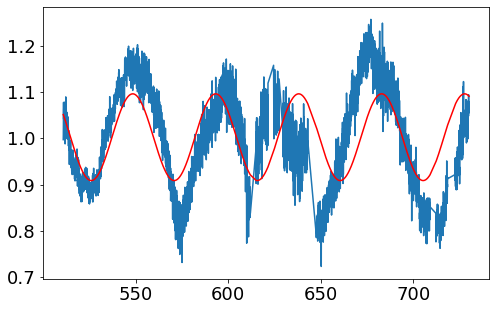

In [10]:
def fit_sin(x, w, phi, A, B):
    return A * np.sin(w * x - phi) + B
fit_sin_model = lmfit.Model(fit_sin)

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('phi', value=2, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results = fit_sin_model.fit(fit_ratio, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results)

plt.plot(cavity_freqs_filtered, fit_ratio)
plt.plot(cavity_freqs_filtered, fit_sin_model.eval(ratio_results.params, x=cavity_freqs_filtered), 'r')

### Fit bounced sinusoidal to fitted cavity ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 5487
    # variables        = 5
    chi-square         = 21.9842758
    reduced chi-square = 0.00401027
    Akaike info crit   = -30277.1946
    Bayesian info crit = -30244.1439
[[Variables]]
    w:     0.12044856 +/- 3.3876e-04 (0.28%) (init = 0.125)
    xref:  613.877368 +/- 0.08254029 (0.01%) (init = 620)
    phi:   4.6456e-08 +/- 0.01520771 (32735975.12%) (init = 3.1)
    A:     0.12426511 +/- 0.00119117 (0.96%) (init = 0.2)
    B:     0.99403107 +/- 8.6256e-04 (0.09%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) = -0.867


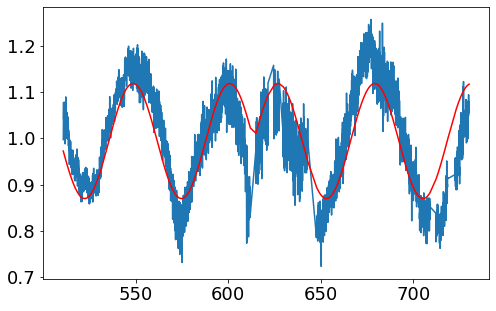

In [11]:
def fit_bounce_sin(x, w, xref, phi, A, B):
    return A * np.sin(w * np.abs(x - xref) - phi) + B
fit_bounce_sin_model = lmfit.Model(fit_bounce_sin)

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('xref', value=620, min=610, max=630),
    Parameter('phi', value=3.1, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results = fit_bounce_sin_model.fit(fit_ratio, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results)

plt.plot(cavity_freqs_filtered, fit_ratio)
plt.plot(cavity_freqs_filtered, fit_bounce_sin_model.eval(ratio_results.params, x=cavity_freqs_filtered), 'r')

## "Fit" cavity function using previously-fit kappas

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 5487
    # variables        = 2
    chi-square         = 1.3688e+11
    reduced chi-square = 24954865.1
    Akaike info crit   = 93459.7626
    Bayesian info crit = 93472.9828
[[Variables]]
    w_c:    643.239976 +/- 0.28015953 (0.04%) (init = 650)
    k_in:   119.118 (fixed)
    k_tot:  164.37 (fixed)
    A:      117134.291 +/- 254.131936 (0.22%) (init = 40000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_c, A) = -0.560


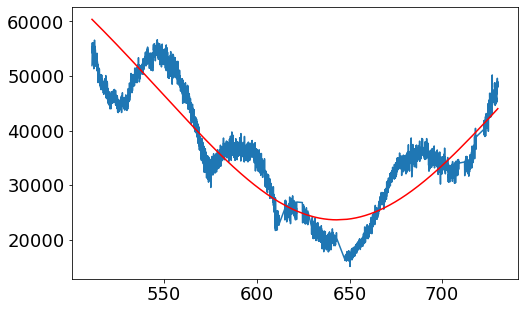

In [12]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=650, min=600, max=700),
    Parameter('k_in', value=119.118, vary=False), #122.56 from the pure cavity fit. 119.118 from SiV fits with gamma fixed and k_in varying.
    Parameter('k_tot', value=164.37, vary=False),
    Parameter('A', value=40000, min=0, max=200000),
    Parameter('B', value=0, vary=False),
)

results_oldk = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered)
lmfit.report_fit(results_oldk)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs_filtered, cavity_ref_model.eval(results_oldk.params, w=cavity_freqs_filtered), 'r')

fit_ratio_oldk = cavity_intensity_filtered / (cavity_intensity_filtered + results_oldk.residual)

### Fit sunusoidal to cavity fit ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 5487
    # variables        = 4
    chi-square         = 89.8617840
    reduced chi-square = 0.01638916
    Akaike info crit   = -22553.7988
    Bayesian info crit = -22527.3582
[[Variables]]
    w:    0.12974760 +/- 5.5845e-04 (0.43%) (init = 0.125)
    phi:  6.28000000 +/- 0.34542327 (5.50%) (init = 2)
    A:    0.07201068 +/- 0.00247809 (3.44%) (init = 0.2)
    B:    1.01219201 +/- 0.00174580 (0.17%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) =  0.995
    C(A, B)   =  0.116
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 5487
    # variables        = 5
    chi-square         = 55.3803842
    reduced chi-square = 0.01010222
    Akaike info crit   = -25207.7663
    Bayesian info crit = -25174.7156
[[Variables]]
    w:     0.12017630 +/- 5.1226e-04 (0.43%) (init = 0.125)
    xref:  613.6439

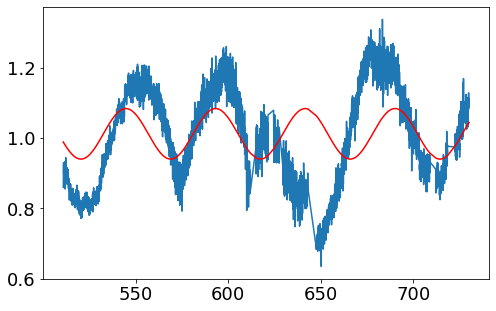

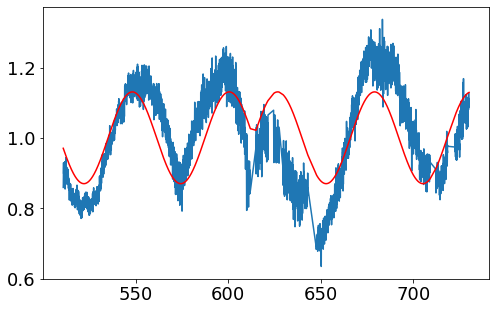

In [13]:
params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('phi', value=2, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results_oldk = fit_sin_model.fit(fit_ratio_oldk, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results_oldk)

plt.plot(cavity_freqs_filtered, fit_ratio_oldk)
plt.plot(cavity_freqs_filtered, fit_sin_model.eval(ratio_results_oldk.params, x=cavity_freqs_filtered), 'r')

################################

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('xref', value=620, min=610, max=630),
    Parameter('phi', value=3.1, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results_oldk = fit_bounce_sin_model.fit(fit_ratio_oldk, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results_oldk)

plt.figure()
plt.plot(cavity_freqs_filtered, fit_ratio_oldk)
plt.plot(cavity_freqs_filtered, fit_bounce_sin_model.eval(ratio_results_oldk.params, x=cavity_freqs_filtered), 'r')

# ----------------------------------------------------------
# Fit SiV Spectrum

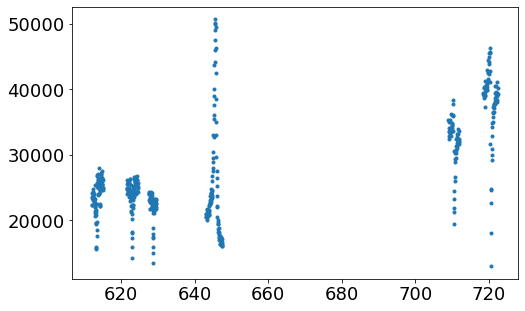

In [14]:
# Plot the regions that were excluded from the cavity fit
siv_indices = in_range(cavity_freqs, filter_range)
cavity_freqs_siv = cavity_freqs[siv_indices]
cavity_intensity_siv = cavity_intensity[siv_indices]

plt.plot(cavity_freqs_siv, cavity_intensity_siv, '.')

## Fitting SiV index 4

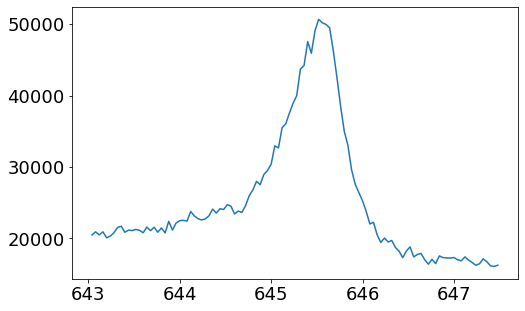

In [15]:
start, end = filter_range[3]
cavity_freqs_siv_4 = cavity_freqs_siv[(cavity_freqs_siv > start) & (cavity_freqs_siv < end)]
cavity_intensity_siv_4 =cavity_intensity_siv[(cavity_freqs_siv > start) & (cavity_freqs_siv < end)]

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)

### Fix B, total kappa, kappa in

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 853
    # data points      = 112
    # variables        = 5
    chi-square         = 54649711.5
    reduced chi-square = 510744.968
    Akaike info crit   = 1476.97103
    Bayesian info crit = 1490.56352
[[Variables]]
    w_up:      645.569898 +/- 0.00371641 (0.00%) (init = 645.5)
    g_up:      6.99087439 +/- 0.05360375 (0.77%) (init = 5.6)
    gamma_up:  0.03627311 +/- 9.5229e-04 (2.63%) (init = 0.05)
    w_c:       622.852861 +/- 0.67100394 (0.11%) (init = 715)
    k_in:      122.5608 (fixed)
    k_tot:     164.3667 (fixed)
    A:         72098.2148 +/- 483.206370 (0.67%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.400)
    C(g_up, A)        = -0.641
    C(w_up, w_c)      = -0.580
    C(g_up, gamma_up) =  0.450
    C(w_c, A)         =  0.443


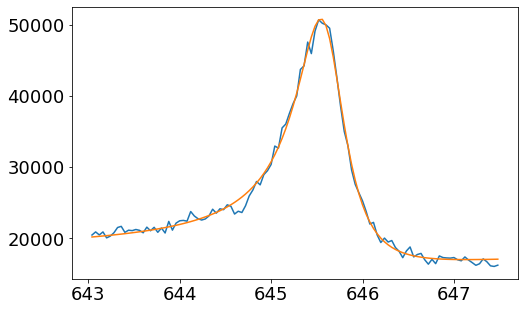

In [16]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=122.560818, vary=False),
    Parameter('k_tot', value=164.366697, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = single_siv_ref_model.fit(cavity_intensity_siv_4, params, w=cavity_freqs_siv_4, method="nealder")
lmfit.report_fit(results, min_correl=0.4)

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)
plt.plot(cavity_freqs_siv_4, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_4))

### Fix B, total kappa, gamma

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1012
    # data points      = 112
    # variables        = 5
    chi-square         = 54794317.3
    reduced chi-square = 512096.423
    Akaike info crit   = 1477.26700
    Bayesian info crit = 1490.85949
[[Variables]]
    w_up:      645.576777 +/- 0.00389288 (0.00%) (init = 645.5)
    g_up:      6.81070311 +/- 0.06176188 (0.91%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       625.689716 +/- 0.56051077 (0.09%) (init = 715)
    k_in:      119.959287 +/- 0.19792439 (0.16%) (init = 122)
    k_tot:     164.3667 (fixed)
    A:         82904.3124 +/- 1008.93557 (1.22%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.400)
    C(g_up, A)    = -0.949
    C(k_in, A)    = -0.844
    C(g_up, k_in) =  0.744
    C(w_up, w_c)  = -0.600


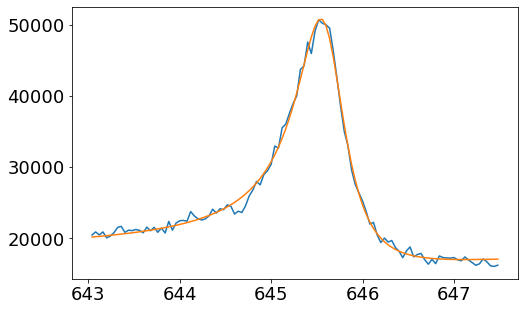

In [17]:
### params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=122, min=100, max=150),
    Parameter('k_tot', value=164.366697, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = single_siv_ref_model.fit(cavity_intensity_siv_4, params, w=cavity_freqs_siv_4, method="nealder")
lmfit.report_fit(results, min_correl=0.4)

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)
plt.plot(cavity_freqs_siv_4, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_4))

## SiV4 MCMC

In [374]:
def mcmc(freqs, counts, model, results, input_params=None):
    # Add additional (nuisance) parameter to model the data uncertainty
    # This range should correspond to the expected noise in the data
    results.params.add('__lnsigma', value=np.log(50), min=np.log(1), max=np.log(5000))
    
    # Default emcee parameters, can be overwritten by input_params
    emcee_params = {"is_weighted": False, "burn": 300, "steps": 6000, "thin": 1}
    if input_params is not None: 
        emcee_params.update(input_params)
    emcee_results = model.fit(counts, results.params, w=freqs, method="emcee", fit_kws=emcee_params)
    
    # Check the autocorrelation time, guideline is num_steps should be 50 x t_cor
    try:
        print(f"Autocorrelation times: {emcee_results.acor}")
        print(f"Max 50 x Autocorrelation times: {max(50 * emcee_results.acor)}\n")
    except AttributeError:
        pass

    fitted_var_names = [param.name for param in emcee_results.params.values() if param.vary]
    fitted_values = [param.value for param in emcee_results.params.values() if param.vary]
    
    # Plot the corner plot for how the variables relate to one another
    emcee_plot = corner.corner(emcee_results.flatchain, labels=emcee_results.var_names, truths=fitted_values)
    
    # General rule of thumb is that acceptance fraction should be ~0.5
    plt.figure()
    plt.plot(emcee_results.acceptance_fraction, 'b') 
    
    # Print the median point from the MCMC chains
    print('Median of posterior probability distribution')
    print('--------------------------------------------')
    lmfit.report_fit(emcee_results.params, min_correl=0.4)
    
    # Obtain the Maximum Likelihood Estimation
    highest_prob_idx = np.argmax(emcee_results.lnprob)
    mle_soln = emcee_results.chain[np.unravel_index(highest_prob_idx, emcee_results.lnprob.shape)]
    # Copy the original results object and replace with MLE values
    emcee_mle_params = emcee_results.params.copy()
    for i, name in enumerate(fitted_var_names):
        emcee_mle_params[name].value = mle_soln[i]

    print('\nMaximum Likelihood Estimation from emcee       ')
    print('-------------------------------------------------')
    print('Parameter  MLE Value   Median Value   Uncertainty')
    for name in fitted_var_names:
        print(f'  {name:5s}  {emcee_mle_params[name].value:11.5f} {emcee_results.params[name].value:11.5f}   {emcee_results.params[name].stderr:11.5f}')
    
    # Return median and max likelihood results
    return emcee_results, emcee_mle_params

100%|███████████████████████████████████████████████████| 6000/6000 [01:15<00:00, 36.70it/s]


Autocorrelation times: [54.6051 71.9317 55.4939 58.7675 80.9921 91.7192]
Max 50 x Autocorrelation times: 4585.957950316658

Median of posterior probability distribution
--------------------------------------------
[[Variables]]
    w_up:       645.576793 +/- 0.00386334 (0.00%) (init = 645.5768)
    g_up:       6.81117732 +/- 0.06285861 (0.92%) (init = 6.810703)
    gamma_up:   0.05 (fixed)
    w_c:        625.684865 +/- 0.55766040 (0.09%) (init = 625.6897)
    k_in:       119.960629 +/- 0.19905259 (0.17%) (init = 119.9593)
    k_tot:      164.3667 (fixed)
    A:          82887.2115 +/- 1028.10357 (1.24%) (init = 82904.31)
    B:          0 (fixed)
    __lnsigma:  6.57457994 +/- 0.06881398 (1.05%) (init = 3.912023)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up, A)    = -0.950
    C(k_in, A)    = -0.847
    C(g_up, k_in) =  0.751
    C(w_up, w_c)  = -0.594
    C(w_c, A)     =  0.291
    C(w_up, g_up) = -0.240
    C(g_up, w_c)  = -0.206
    C(w_up, k_in) = -0.175
    C

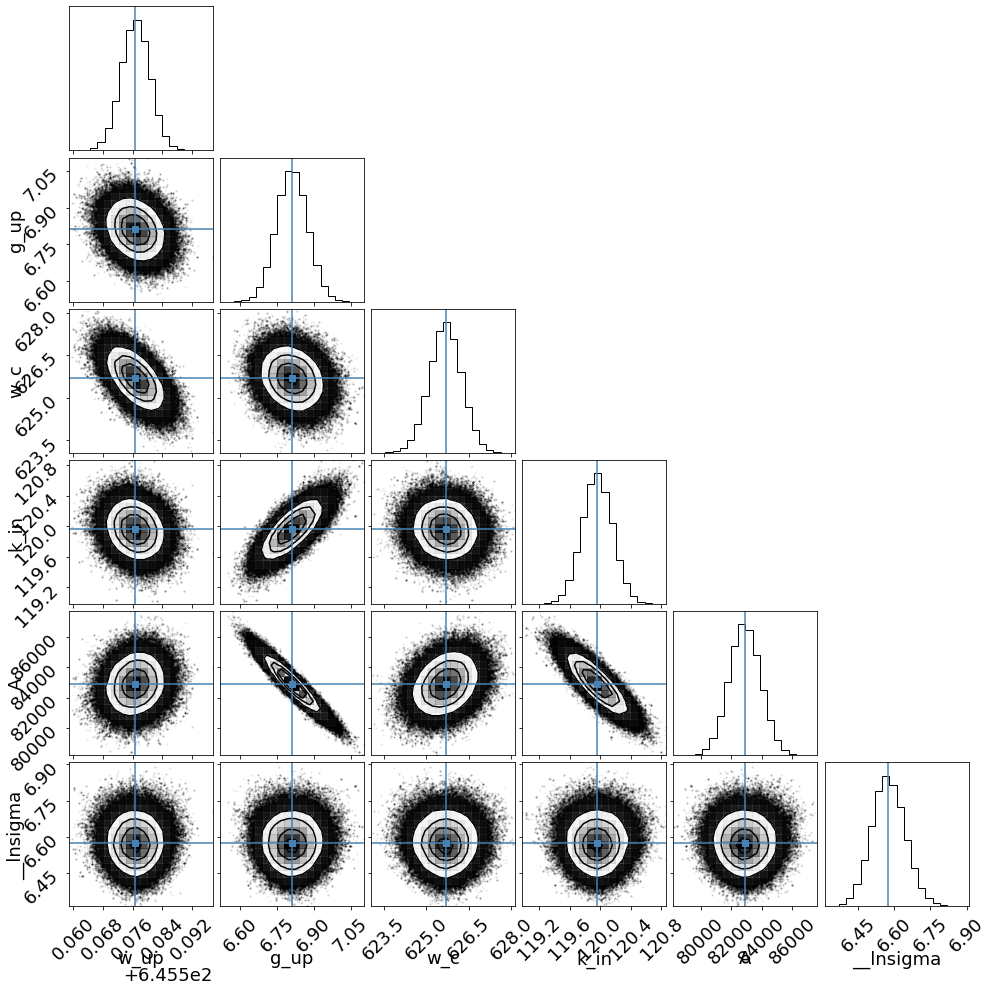

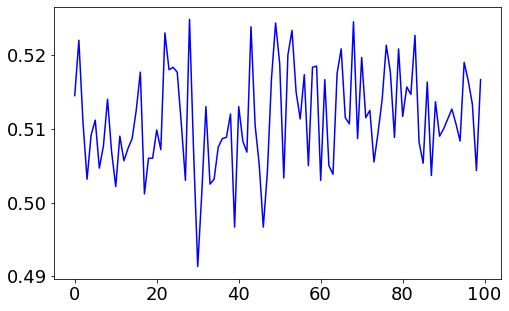

In [375]:
emcee_results, emcee_mle_params = mcmc(cavity_freqs_siv_4, cavity_intensity_siv_4, single_siv_ref_model, results)

## Fitting SiV index 3

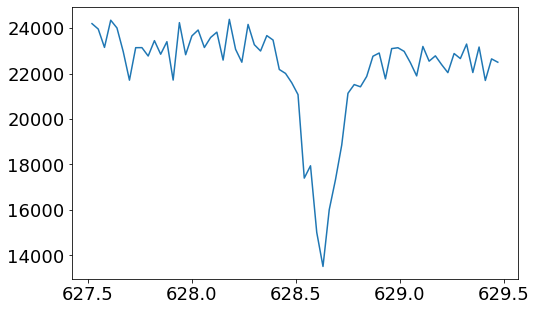

In [416]:
start, end = filter_range[2]
cavity_freqs_siv_3 = cavity_freqs_siv[(cavity_freqs_siv > start) & (cavity_freqs_siv < end)]
cavity_intensity_siv_3 =cavity_intensity_siv[(cavity_freqs_siv > start) & (cavity_freqs_siv < end)]

plt.plot(cavity_freqs_siv_3, cavity_intensity_siv_3)

### Fix B, total kappa, kappa in

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 955
    # data points      = 66
    # variables        = 5
    chi-square         = 29094280.8
    reduced chi-square = 476955.423
    Akaike info crit   = 867.762231
    Bayesian info crit = 878.710504
[[Variables]]
    w_up:      628.612975 +/- 0.00656884 (0.00%) (init = 628.7)
    g_up:      2.71676469 +/- 0.11710912 (4.31%) (init = 5.6)
    gamma_up:  0.03179808 +/- 0.00238070 (7.49%) (init = 0.1)
    w_c:       625.421703 +/- 1.09415466 (0.17%) (init = 622)
    k_in:      122.5608 (fixed)
    k_tot:     164.3667 (fixed)
    A:         96294.1170 +/- 470.937667 (0.49%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.400)
    C(g_up, gamma_up) =  0.983
    C(w_up, w_c)      =  0.768
    C(gamma_up, A)    =  0.491
    C(g_up, A)        =  0.422


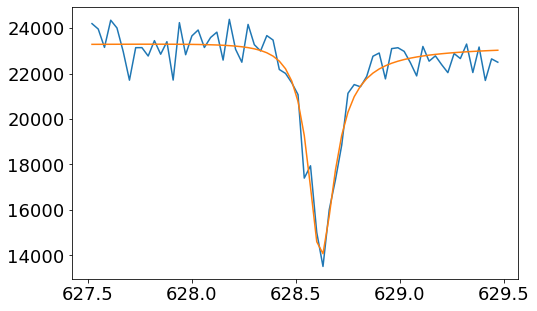

In [417]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=628.7, min=628.25, max=629),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=622, min=0, max=1000),
    Parameter('k_in', value=122.560818, vary=False),
    Parameter('k_tot', value=164.366697, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = single_siv_ref_model.fit(cavity_intensity_siv_3, params, w=cavity_freqs_siv_3, method="nealder")
lmfit.report_fit(results, min_correl=0.4)

plt.plot(cavity_freqs_siv_3, cavity_intensity_siv_3)
plt.plot(cavity_freqs_siv_3, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_3))

### Fix B, total kappa, gamma

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1100
    # data points      = 66
    # variables        = 5
    chi-square         = 29211229.9
    reduced chi-square = 478872.622
    Akaike info crit   = 868.026997
    Bayesian info crit = 878.975270
[[Variables]]
    w_up:      628.613603 +/- 0.00647622 (0.00%) (init = 628.7)
    g_up:      2.10683529 +/- 0.24203590 (11.49%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       627.534693 +/- 0.44904040 (0.07%) (init = 622)
    k_in:      102.410899 +/- 3.63739305 (3.55%) (init = 122)
    k_tot:     164.3667 (fixed)
    A:         385193.996 +/- 138039.014 (35.84%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)    = -1.000
    C(g_up, A)    = -0.999
    C(g_up, k_in) =  0.999
    C(w_up, w_c)  =  0.716
    C(g_up, w_c)  = -0.548
    C(w_c, A)     =  0.544
    C(w_c, k_in)  = -0.542
    C(w_up, g_up) = -0.140
    C(w_up, A)    =  0.133
   

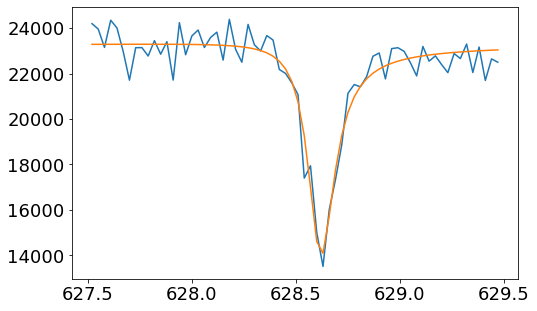

In [403]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=628.7, min=628.25, max=629),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=622, min=0, max=1000),
    Parameter('k_in', value=122, min=100, max=150),
    Parameter('k_tot', value=164.366697, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = single_siv_ref_model.fit(cavity_intensity_siv_3, params, w=cavity_freqs_siv_3, method="nealder")
lmfit.report_fit(results, min_correl=0.4)

plt.plot(cavity_freqs_siv_3, cavity_intensity_siv_3)
plt.plot(cavity_freqs_siv_3, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_3))

100%|█████████████████████████████████████████████████| 15000/15000 [02:55<00:00, 85.45it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: [135.5782 712.9237 220.5224 723.0739 703.5186 116.8971]


Median of posterior probability distribution
--------------------------------------------
[[Variables]]
    w_up:       628.613049 +/- 0.00666933 (0.00%) (init = 628.6136)
    g_up:       2.20396209 +/- 0.18146634 (8.23%) (init = 2.106835)
    gamma_up:   0.05 (fixed)
    w_c:        627.429416 +/- 0.45055470 (0.07%) (init = 627.5347)
    k_in:       103.857986 +/- 2.74024369 (2.64%) (init = 102.4109)
    k_tot:      164.3667 (fixed)
    A:          335569.150 +/- 84106.5776 (25.06%) (init = 385194)
    B:          0 (fixed)
    __lnsigma:  6.54227904 +/- 0.09174264 (1.40%) (init = 3.912023)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up, k_in)      =  0.996
    C(k_in, A)         = -0.981
    C(g_up, A)         = -0.979
    C(w_up, __lnsigma) = -0.569
    C(g_up, w_c)       = -0.397
    C(w_up, w_c)       =  0.389
    C(w_c, k_in)       = -0.377
    C(w_c, A)          =  0.372
    C(w_c, __lnsigma)  = -0.127

Maximum Likelihood Estimation from emcee       
---------

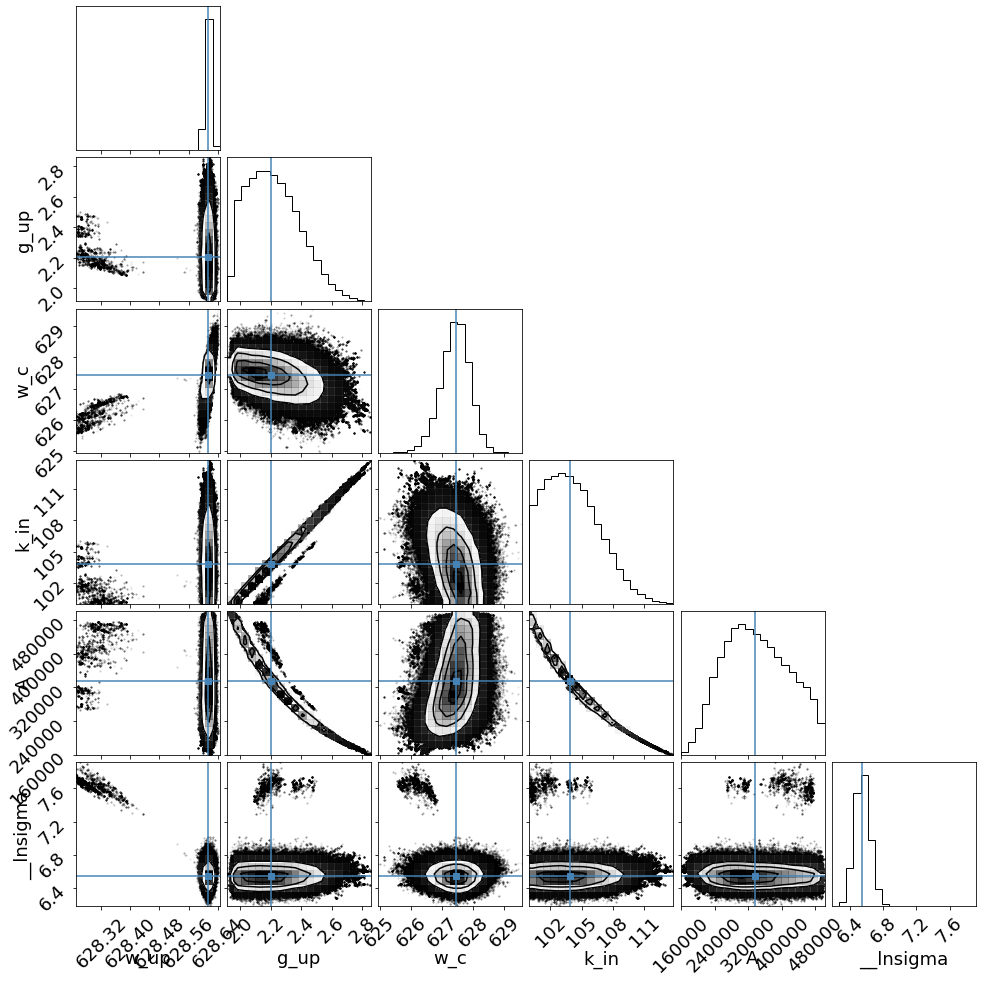

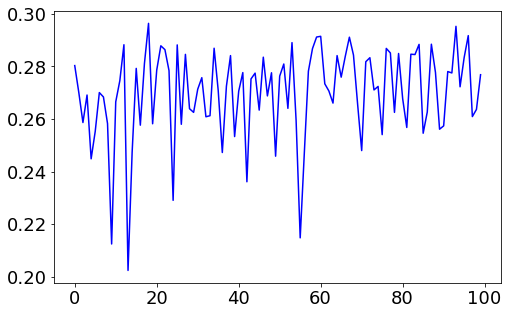

In [405]:
emcee_results, emcee_mle_params = mcmc(cavity_freqs_siv_3, cavity_intensity_siv_3, single_siv_ref_model, results, {"steps": 15000})

# Fitting 3 SiVs

In [406]:
def multiple_siv_objective(params, w_arr, data_arr):
    p = params.valuesdict()
    resid = []
    
    B = p["B"]
    w_c = p["w_c"]
    k_in = p["k_in"]
    k_tot = p["k_tot"]
    gamma_up = p["gamma_up"]

    # make residual per data set
    for i in range(len(data_arr)):
        w = w_arr[i]
        A = p[f"A_{i}"]
        g_up = p[f"g_up_{i}"] 
        w_up = p[f"w_up_{i}"]
        
        resid.append(data_arr[i] - fitter.single_siv_ref(w, w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B))
    
    # now flatten this to a 1D array, as minimize() needs
    return np.array([item for sublist in resid for item in sublist])

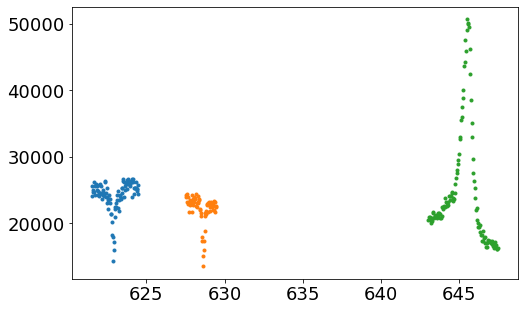

In [407]:
siv_freq_arr = []
siv_intensity_arr = []

for f_range in filter_range[1:4]:
    siv_indices = in_range(cavity_freqs, [f_range])
    siv_freq_arr.append(cavity_freqs[siv_indices])
    siv_intensity_arr.append(cavity_intensity[siv_indices])
    
    plt.plot(cavity_freqs[siv_indices], cavity_intensity[siv_indices], '.')

In [408]:
params = Parameters()
params.add_many(
    Parameter('w_up_0', value=622.7, min=622.5, max=630.2),
    Parameter('g_up_0', value=5.6, min=1, max=10),
    Parameter('A_0', value=60000, min=5000, max=900000),
    
    Parameter('w_up_1', value=628.7, min=628.5, max=629),
    Parameter('g_up_1', value=5.6, min=1, max=10),
    Parameter('A_1', value=60000, min=5000, max=900000),
    
    Parameter('w_up_2', value=645.5, min=645, max=646),
    Parameter('g_up_2', value=5.6, min=1, max=10),
    Parameter('A_2', value=60000, min=5000, max=900000),
    
    Parameter('w_c', value=622, min=0, max=1000),
    Parameter('k_in', value=122.560818, min=100, max=150),
    Parameter('k_tot', value=164.366697, vary=False),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('B', value=0, vary=False),
)

results = lmfit.minimize(multiple_siv_objective, params, args=(siv_freq_arr, siv_intensity_arr))#, method="nealder")
lmfit.report_fit(results, min_correl=0.4)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 183
    # data points      = 278
    # variables        = 11
    chi-square         = 1.7907e+08
    reduced chi-square = 670675.380
    Akaike info crit   = 3740.43572
    Bayesian info crit = 3780.33955
[[Variables]]
    w_up_0:    622.890197 +/- 0.00689008 (0.00%) (init = 622.7)
    g_up_0:    3.26650098 +/- 0.02593622 (0.79%) (init = 5.6)
    A_0:       120434.488 +/- 1476.65651 (1.23%) (init = 60000)
    w_up_1:    628.602895 +/- 0.00807103 (0.00%) (init = 628.7)
    g_up_1:    3.31271886 +/- 0.02825751 (0.85%) (init = 5.6)
    A_1:       111577.330 +/- 1426.99738 (1.28%) (init = 60000)
    w_up_2:    645.578636 +/- 0.00400091 (0.00%) (init = 645.5)
    g_up_2:    6.80712029 +/- 0.06937792 (1.02%) (init = 5.6)
    A_2:       82928.7951 +/- 1122.34476 (1.35%) (init = 60000)
    w_c:       625.300990 +/- 0.44780380 (0.07%) (init = 622)
    k_in:      119.917707 +/- 0.22445856 (0.19%) (init = 122.5608)
    k

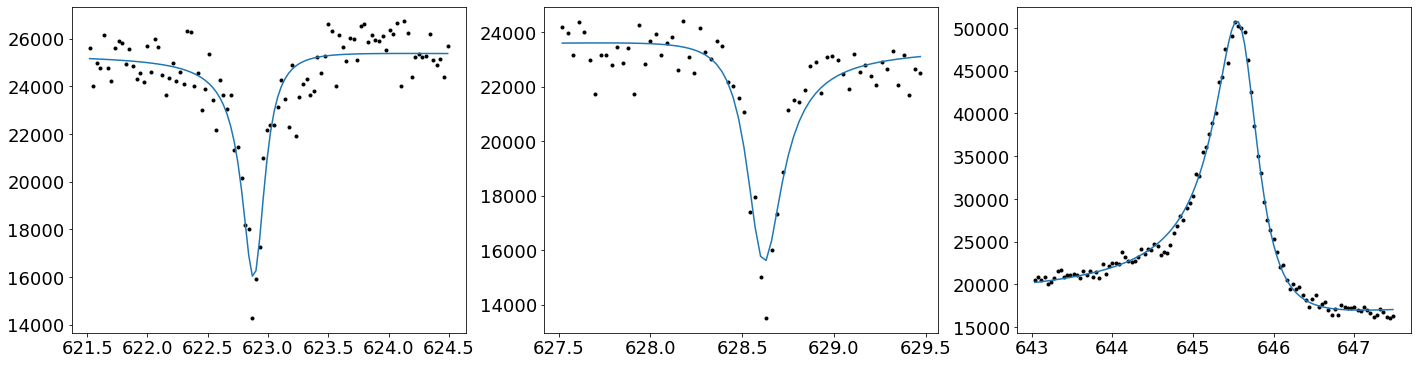

In [391]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[24, 6])
p = results.params.valuesdict()
B = p["B"]
w_c = p["w_c"]
k_in = p["k_in"]
k_tot = p["k_tot"]
gamma_up = p["gamma_up"]

for i in range(len(siv_intensity_arr)):
    freqs = siv_freq_arr[i]
    data = siv_intensity_arr[i]
    A = p[f"A_{i}"]
    g_up = p[f"g_up_{i}"] 
    w_up = p[f"w_up_{i}"]
    ax[i].plot(freqs, data, 'k.')
    ax[i].plot(freqs, fitter.single_siv_ref(freqs, w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B))
plt.show()

# More SiVs

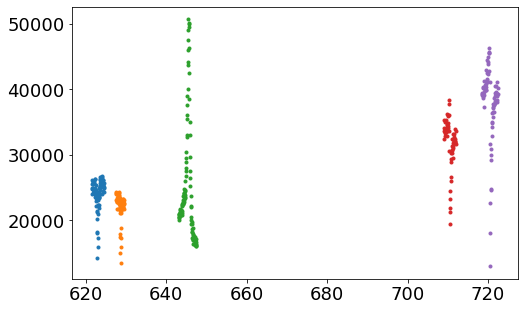

In [424]:
siv_freq_arr = []
siv_intensity_arr = []

for f_range in filter_range[1:6]:
    siv_indices = in_range(cavity_freqs, [f_range])
    siv_freq_arr.append(cavity_freqs[siv_indices])
    siv_intensity_arr.append(cavity_intensity[siv_indices])
    
    plt.plot(cavity_freqs[siv_indices], cavity_intensity[siv_indices], '.')

## Freely fit the amplitudes

In [438]:
params = Parameters()
params.add_many(
    Parameter('w_up_0', value=622.8, min=622.5, max=623.2),
    Parameter('g_up_0', value=5.6, min=1, max=10),
    
    Parameter('w_up_1', value=628.7, min=628.5, max=629),
    Parameter('g_up_1', value=5.6, min=1, max=10),
    
    Parameter('w_up_2', value=645.5, min=645, max=646),
    Parameter('g_up_2', value=5.6, min=1, max=10),
    
    Parameter('w_up_3', value=710.5, min=710, max=711),
    Parameter('g_up_3', value=5.6, min=1, max=10),
   
    Parameter('w_up_4', value=720.5, min=720, max=721),
    Parameter('g_up_4', value=5.6, min=1, max=10),
    
    Parameter('w_c', value=622, min=0, max=1000),
    Parameter('k_in', value=122.560818, min=100, max=160),
    Parameter('k_tot', value=164.366697, vary=False),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('A_0', value=60000, min=5000, max=900000),
    Parameter('A_1', value=60000, min=5000, max=900000),
    Parameter('A_2', value=60000, min=5000, max=900000),
    Parameter('A_3', value=60000, min=5000, max=900000),
    Parameter('A_4', value=60000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = lmfit.minimize(multiple_siv_objective, params, args=(siv_freq_arr, siv_intensity_arr))#, method="nealder")
lmfit.report_fit(results, min_correl=0.5)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 382
    # data points      = 419
    # variables        = 17
    chi-square         = 7.0920e+08
    reduced chi-square = 1764170.23
    Akaike info crit   = 6043.20254
    Bayesian info crit = 6111.84635
[[Variables]]
    w_up_0:    622.889678 +/- 0.01097024 (0.00%) (init = 622.8)
    g_up_0:    3.20838134 +/- 0.04093770 (1.28%) (init = 5.6)
    w_up_1:    628.601370 +/- 0.01287095 (0.00%) (init = 628.7)
    g_up_1:    3.25485794 +/- 0.04473756 (1.37%) (init = 5.6)
    w_up_2:    645.582907 +/- 0.00614650 (0.00%) (init = 645.5)
    g_up_2:    6.62390210 +/- 0.10714364 (1.62%) (init = 5.6)
    w_up_3:    710.474457 +/- 0.00389656 (0.00%) (init = 710.5)
    g_up_3:    1.44888101 +/- 0.04548966 (3.14%) (init = 5.6)
    w_up_4:    720.493078 +/- 0.00261444 (0.00%) (init = 720.5)
    g_up_4:    2.11021004 +/- 0.04391409 (2.08%) (init = 5.6)
    w_c:       625.182728 +/- 0.70508511 (0.11%) (init = 622)
    k_in:   

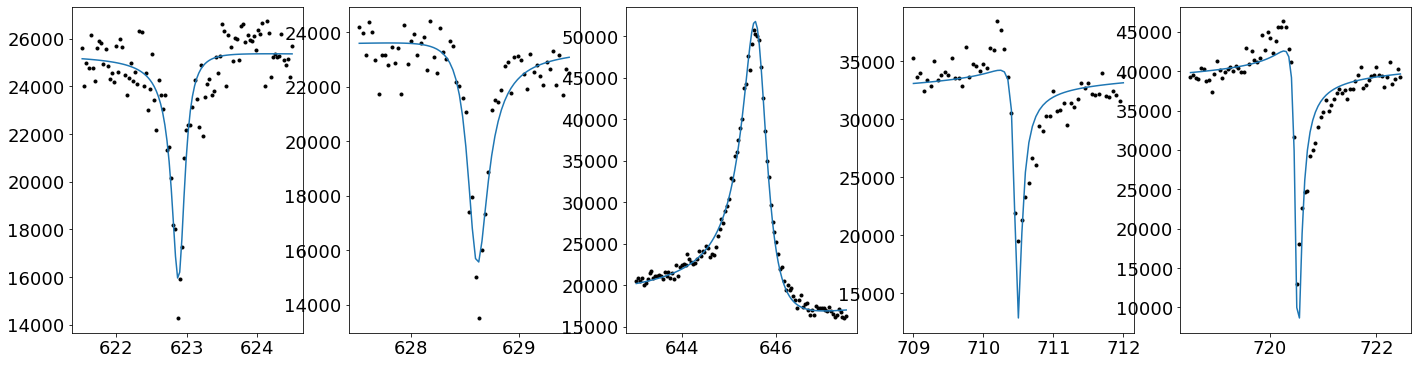

In [439]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[24, 6])
p = results.params.valuesdict()
B = p["B"]
w_c = p["w_c"]
k_in = p["k_in"]
k_tot = p["k_tot"]
gamma_up = p["gamma_up"]

for i in range(len(siv_intensity_arr)):
    freqs = siv_freq_arr[i]
    data = siv_intensity_arr[i]
    A = p[f"A_{i}"]
    g_up = p[f"g_up_{i}"] 
    w_up = p[f"w_up_{i}"]
    ax[i].plot(freqs, data, 'k.')
    ax[i].plot(freqs, fitter.single_siv_ref(freqs, w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B))
plt.show()

In [427]:
fitted_A_ratios = np.array([results.params[f"A_{i}"].value for i in range(5)])
fitted_A_ratios / fitted_A_ratios[2] # Fitted amplitudes normalized to the large peak

array([1.4544, 1.3466, 1.    , 1.0329, 1.1432])

### MCMC for multiple-SiV with most parameters fixed

In [441]:
for param in results.params:
    results.params[param].vary = False
results.params["w_c"].vary = True
results.params["k_in"].vary = True
results.params["w_up_2"].vary = True
results.params["g_up_2"].vary = True

In [442]:
results.params.add('__lnsigma', value=np.log(50), min=np.log(1), max=np.log(5000))
emcee_params = {"is_weighted": False, "burn": 300, "steps": 6000, "thin": 1}

emcee_results = lmfit.minimize(multiple_siv_objective, results.params, args=(siv_freq_arr, siv_intensity_arr), method="emcee", **emcee_params)

100%|███████████████████████████████████████████████████| 6000/6000 [03:21<00:00, 29.71it/s]


Autocorrelation times: [49.0716 71.9518 36.5983 53.917  40.3911]
Max 50 x Autocorrelation times: 3597.5917452930107

Median of posterior probability distribution
--------------------------------------------
[[Variables]]
    w_up_0:     622.8897 (fixed)
    g_up_0:     3.208381 (fixed)
    w_up_1:     628.6014 (fixed)
    g_up_1:     3.254858 (fixed)
    w_up_2:     645.582893 +/- 0.00519483 (0.00%) (init = 645.5829)
    g_up_2:     6.62383035 +/- 0.03038708 (0.46%) (init = 6.623902)
    w_up_3:     710.4745 (fixed)
    g_up_3:     1.448881 (fixed)
    w_up_4:     720.4931 (fixed)
    g_up_4:     2.11021 (fixed)
    w_c:        625.179382 +/- 0.33194244 (0.05%) (init = 625.1827)
    k_in:       119.117791 +/- 0.07542327 (0.06%) (init = 119.118)
    k_tot:      164.3667 (fixed)
    gamma_up:   0.05 (fixed)
    A_0:        125657.9 (fixed)
    A_1:        116344.8 (fixed)
    A_2:        86397.01 (fixed)
    A_3:        89235.55 (fixed)
    A_4:        98766.27 (fixed)
    B:          0 

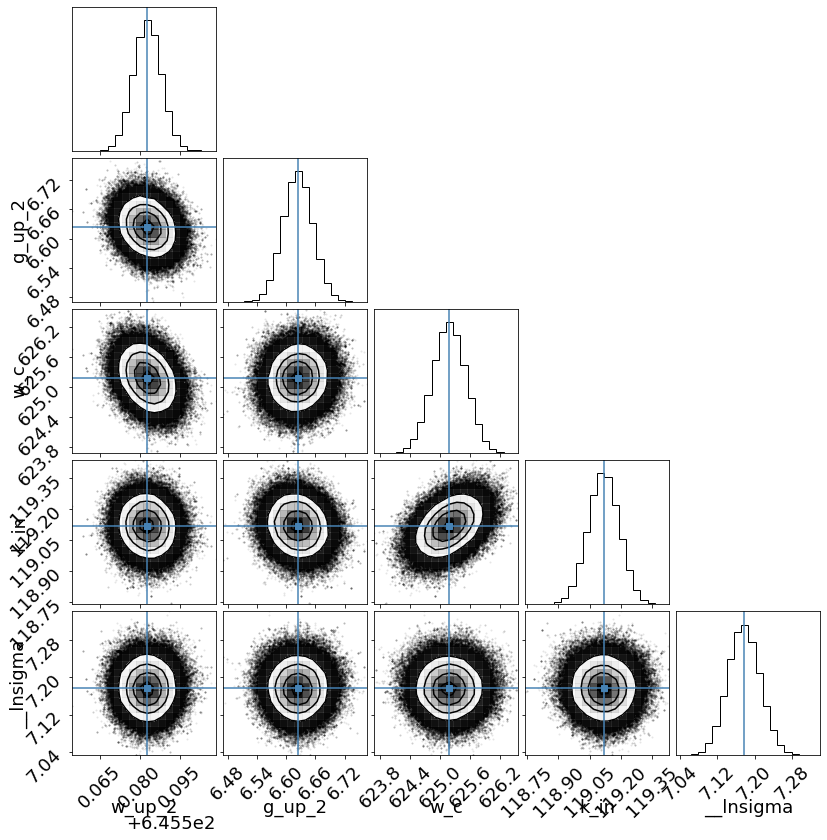

In [445]:
try:
    print(f"Autocorrelation times: {emcee_results.acor}")
    print(f"Max 50 x Autocorrelation times: {max(50 * emcee_results.acor)}\n")
except AttributeError:
    pass

fitted_var_names = [param.name for param in emcee_results.params.values() if param.vary]
fitted_values = [param.value for param in emcee_results.params.values() if param.vary]

emcee_plot = corner.corner(emcee_results.flatchain, labels=emcee_results.var_names, truths=fitted_values)

print('Median of posterior probability distribution')
print('--------------------------------------------')
lmfit.report_fit(emcee_results.params, min_correl=0.4)

highest_prob_idx = np.argmax(emcee_results.lnprob)
mle_soln = emcee_results.chain[np.unravel_index(highest_prob_idx, emcee_results.lnprob.shape)]

emcee_mle_params = emcee_results.params.copy()
for i, name in enumerate(fitted_var_names):
    emcee_mle_params[name].value = mle_soln[i]

print('\nMaximum Likelihood Estimation from emcee       ')
print('-------------------------------------------------')
print('Parameter  MLE Value   Median Value   Uncertainty')
for name in fitted_var_names:
    print(f'  {name:5s}  {emcee_mle_params[name].value:11.5f} {emcee_results.params[name].value:11.5f}   {emcee_results.params[name].stderr:11.5f}')

## Fix the SiV amplitude ratios based on surrounding baselines

[1.3102 1.2203 1.     1.1601 1.2403]


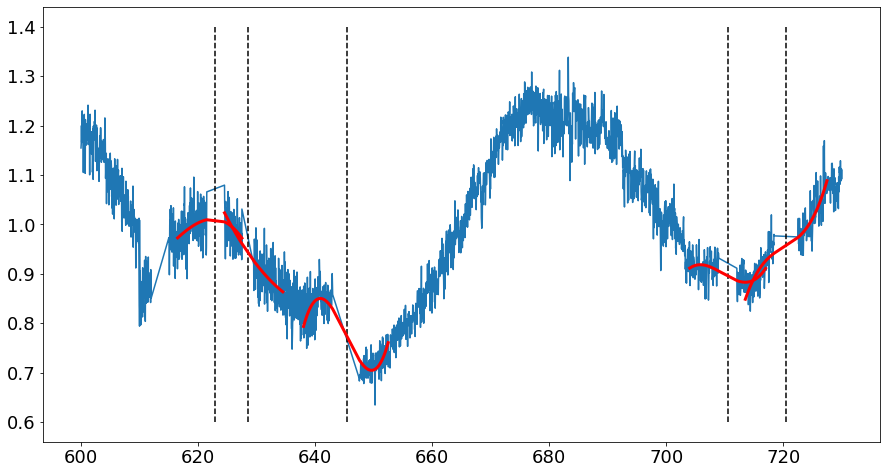

In [458]:
plt.figure(figsize=[15, 8])
# PLot fit_ratio, the ratio of ACTUAL cavity signal with the fitted ideal cavity shape
# This acts as a proxy for the sinusoidal oscillations 
plt.plot(cavity_freqs_filtered[cavity_freqs_filtered>600], fit_ratio_oldk[cavity_freqs_filtered>600])

# Expand the filter range to include the surroundings for computing the linear regression
expanded_filter_range = [(start-5, end+5) for (start, end) in filter_range]

# Estimated SiV peaks by eye
estimated_siv_w = [622.85, 628.6, 645.5, 710.5, 720.5]
for w in estimated_siv_w:
    plt.plot([w, w], [0.6, 1.4], 'k--')
    
estimated_A_ratio = []
# Near each peak, do a poly fit without the peak and evaluate at the peak location
for i, f_range in enumerate(expanded_filter_range[1:]):
    # Indices and freqs of the region around the peak
    expanded_indices = in_range(cavity_freqs_filtered, [f_range])
    freqs = cavity_freqs_filtered[expanded_indices]
    
    # Fit the ratio of cavity vs cavity-fit
    poly = np.poly1d(np.polyfit(freqs, fit_ratio_oldk[expanded_indices], 3))
    plt.plot(freqs, poly(freqs), 'r', lw=3)
    
    # Compute the fitted value at the peak location
    estimated_A_ratio.append(poly(estimated_siv_w[i]))

# Expected relative intensity "A" for each peak, normalized to the large peak in the middle
estimated_A_ratio = np.array(estimated_A_ratio) / estimated_A_ratio[2]
print(estimated_A_ratio)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 435
    # data points      = 419
    # variables        = 13
    chi-square         = 1.1968e+09
    reduced chi-square = 2947782.21
    Akaike info crit   = 6254.45423
    Bayesian info crit = 6306.94655
[[Variables]]
    w_up_0:    622.939662 +/- 0.01771387 (0.00%) (init = 622.8)
    g_up_0:    3.58471853 +/- 0.05038298 (1.41%) (init = 5.6)
    w_up_1:    628.653528 +/- 0.02170169 (0.00%) (init = 628.7)
    g_up_1:    3.59483396 +/- 0.04955197 (1.38%) (init = 5.6)
    w_up_2:    645.546869 +/- 0.00858903 (0.00%) (init = 645.5)
    g_up_2:    7.09961435 +/- 0.07067079 (1.00%) (init = 5.6)
    w_up_3:    710.479631 +/- 0.00476038 (0.00%) (init = 710.5)
    g_up_3:    1.49235367 +/- 0.05596061 (3.75%) (init = 5.6)
    w_up_4:    720.498449 +/- 0.00332368 (0.00%) (init = 720.5)
    g_up_4:    2.06278896 +/- 0.05738886 (2.78%) (init = 5.6)
    w_c:       631.145156 +/- 0.80550467 (0.13%) (init = 622)
    k_in:   

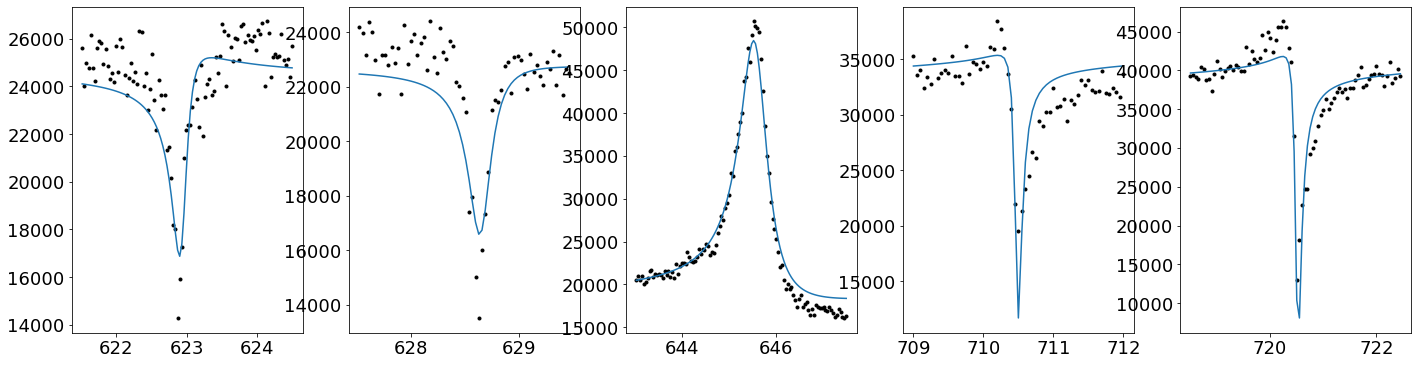

In [459]:
params = Parameters()
params.add_many(
    Parameter('w_up_0', value=622.8, min=622.5, max=623.2),
    Parameter('g_up_0', value=5.6, min=1, max=10),
    
    Parameter('w_up_1', value=628.7, min=628.5, max=629),
    Parameter('g_up_1', value=5.6, min=1, max=10),
    
    Parameter('w_up_2', value=645.5, min=645, max=646),
    Parameter('g_up_2', value=5.6, min=1, max=10),
    
    Parameter('w_up_3', value=710.5, min=710, max=711),
    Parameter('g_up_3', value=5.6, min=1, max=10),
   
    Parameter('w_up_4', value=720.5, min=720, max=721),
    Parameter('g_up_4', value=5.6, min=1, max=10),
    
    Parameter('w_c', value=622, min=0, max=1000),
    Parameter('k_in', value=122.560818, min=100, max=160),
    Parameter('k_tot', value=164.366697, vary=False),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('A_0', expr=f"{estimated_A_ratio[0]} * A_2"),
    Parameter('A_1', expr=f"{estimated_A_ratio[1]} * A_2"),
    Parameter('A_2', value=60000, min=5000, max=900000),
    Parameter('A_3', expr=f"{estimated_A_ratio[3]} * A_2"),
    Parameter('A_4', expr=f"{estimated_A_ratio[4]} * A_2"),
    Parameter('B', value=0, vary=False),
)

results = lmfit.minimize(multiple_siv_objective, params, args=(siv_freq_arr, siv_intensity_arr))#, method="nealder")
lmfit.report_fit(results, min_correl=0.4)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[24, 6])
p = results.params.valuesdict()
B = p["B"]
w_c = p["w_c"]
k_in = p["k_in"]
k_tot = p["k_tot"]
gamma_up = p["gamma_up"]

for i in range(len(siv_intensity_arr)):
    freqs = siv_freq_arr[i]
    data = siv_intensity_arr[i]
    A = p[f"A_{i}"]
    g_up = p[f"g_up_{i}"] 
    w_up = p[f"w_up_{i}"]
    ax[i].plot(freqs, data, 'k.')
    ax[i].plot(freqs, fitter.single_siv_ref(freqs, w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B))
plt.show()